In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from calculate_fft import *
from generate_data import generate_data
from transfer_calculation import *

%config InlineBackend.figure_format = 'svg'

## Frequency Sweep
In order to estimate the transfer response for both magnitude and phase, a frequency sweep is performed to measure the systems transfer response for a range of frequencies. 

## Magnitude Response
The magnitude response of a system is defined as $ |H(s)| = \frac{|Y(s)|}{|X(s)|} $ where $ Y(s) $ is the DTFT of the measured output signal and $X(s)$ is the DTFT of the "generated" input signal. While performing a frequency sweep, the input of the system only contains one frequency component at a time. So, the magnitude response can be calculated by just capturing the magnitude of the input DTFT and the magnitude of the output DTFT at the index where the frequency component is located. After capturing the magnitude of both in- and output DTFT's the magnitude is calculated. Consequently, this magnitude response is stored at the index that was determined earlier.  

## Phase response


## Bin size selection
A DTFT is numericly calculating the frequency domain using a finite discrete time domain signal. Since the time domain signal is finite we need to consider the bin size of this data.

### Constant bin size
This method is not taking into account any problems that could occur. While using a constant bin size, a smearing effect in the frequency domain will occur. This is not desired since information about the transfer could be lost.

### Period dependend bin size
In order to reduce the smearing effect, the bin size could be matched to the a multiple of the period of the input signal. It is known that the input signal is a sine, so the period is easilly obtained. The advantage of matching the bin size to the period of the input signal is that the frequency domain is not spreaded. It will result power distributed over only the frequency component that is present thus, one clear peak. The disadvantage is that the bin sizes also are not equal so before storing all responses into one bin, all bin sizes need to be scaled to one bin size. This method results in less resolution for higher frequencies (since those need to be scaled up, thus streched out). 

### Windowing constant bin size
Since a constant bin size is desired for keeping the timing of the data stream simple. Also, an advantage of constant bin size is that the resolution for each frequency component is the same, so no streching effect for higher frequencies. Windowing in the time domain is simply multiplying the time domain data with the chosen window. This is equivalent to convolution in the frequency domain.

### Make use of power near highest peak
Using the fact that the power in the frequency is conserved, the power of a spreaded peak can be restored. When the power of one frequency component is spread out around the peak, this can be recovered by selecting a range around this dominant peak and summing the power and placing it back at the index of the dominant peak. This is equivalent to the windowing method but this is theoretically less complex and can be tuned by trial and error. Parsevals relation can be used to obtain the total power in this selected region. $P=|H(f)|^2$

In [2]:
# Get data for constant bin size methods
# system constants:
start = 1.58e6
stop = 1.68e6
sample_rate = 65e6
periods_per_bin = 100
n_sweeps = 5

bin_size = periods_per_bin*sample_rate/start
duration = periods_per_bin/start

data_in = np.zeros((n_sweeps, int(bin_size)))
data_out = np.zeros((n_sweeps, int(bin_size)))

data_in, data_out, time_axis = frequency_sweep(start, stop, sample_rate, duration, n_sweeps)

In [3]:
""" Constant bin size """
# Get fft's 
figure = False
const_bin_fft_in = np.zeros((n_sweeps, int(bin_size//2)), dtype='complex_')
const_bin_fft_out = np.zeros((n_sweeps, int(bin_size//2)),dtype='complex_')

for i in range(n_sweeps):   
    omega_in, const_bin_fft_in[i] = np.copy(calculate_signal_fft(time_axis, data_in[i], sample_rate))
    omega_out, const_bin_fft_out[i] = np.copy(calculate_signal_fft(time_axis, data_out[i], sample_rate))

# print(data_in[i].size)
# Plot
if figure:
    plt.figure()
    plt.stem(omega_in, np.abs(const_bin_fft_in[4]))
    plt.show()

    omega_test1, fft_test1 = calculate_signal_fft(time_axis, data_in[2], sample_rate)
    omega_test, fft_test = calculate_signal_fft(time_axis, data_in[4], sample_rate)

    plt.figure()
    plt.stem(omega_in, np.abs(fft_test1))
    plt.show()
    plt.figure()
    plt.stem(omega_in, np.abs(fft_test))
    plt.show()

    fig, ax = plt.subplots(n_sweeps)
    for i in range(n_sweeps):
        ax[i].stem(omega_in, np.abs(const_bin_fft_in[i]))
        ax[i].set_xlim([0, 2*stop])
    plt.show()

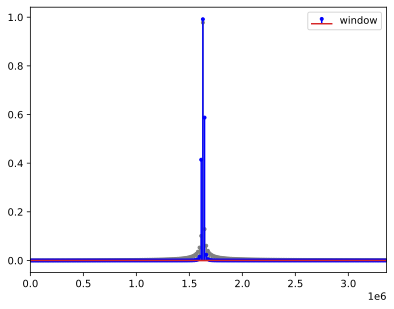

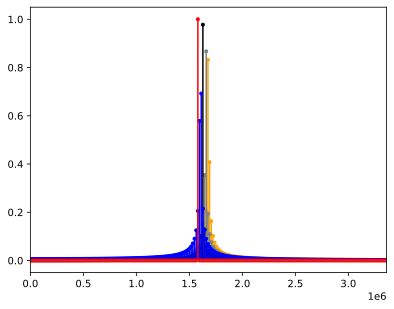

In [4]:
""" Example: Hann window """
hann_window = np.copy(signal.windows.hann(int(bin_size), False))
hann_window_true = np.copy(signal.windows.hann(int(bin_size), True))
samples = np.linspace(0, int(bin_size), num=int(bin_size))

data_in_window = np.zeros((n_sweeps, int(bin_size//2)), dtype='complex_')

# multiply data with window
for i in range(5):
    data_window = np.copy(hann_window*data_in[i,:])
    # print(data_in_window.shape)
    omega_window, data_in_window[i,:] = calculate_signal_fft(time_axis, data_window, sample_rate)

# omega_window, fft_window = calculate_signal_fft(time_axis, data_in_window, sample_rate)
plt.figure()
col = ['red', 'blue', 'black', 'grey', 'orange']
plt.stem(omega_window, np.abs(const_bin_fft_in[2]), markerfmt=".", linefmt='grey')
plt.stem(omega_window, 2*np.abs(data_in_window[2]), markerfmt=".", linefmt='blue', label="window")
plt.xlim([0, 2*stop])
plt.legend()
plt.show()
plt.figure()
col = ['red', 'blue', 'black', 'grey', 'orange']
for i in range(5):
    j = 4-i
    plt.stem(omega_window, np.abs(const_bin_fft_in[j]), linefmt=col[j], markerfmt=".")

plt.xlim([0, 2*stop])
plt.show()
# plt.figure()
# plt.plot(samples, hann_window_true)
# plt.show()

In [5]:
# Helper functions: 
def get_max_index(input_array):
    """Get max index of input array"""
    return np.where(input_array == np.max(input_array))[0]

In [6]:
from scipy.fft import rfft, rfftfreq
# system constants:
start = 1.58e6
stop = 1.68e6
sample_rate = 65e6
periods_per_bin = 100
n_sweeps = 5

# size around max peak collected
power_bin_size = 2

# bin size and duration:
bin_size = periods_per_bin*sample_rate/start
duration = periods_per_bin/start

# Define arrays
data_in = np.zeros((n_sweeps, int(bin_size)))
data_out = np.zeros((n_sweeps, int(bin_size)))

# sweep frequency
data_in, data_out, time_axis = frequency_sweep(start, stop, sample_rate, duration, n_sweeps)

# Define window
hann_window = np.copy(signal.windows.hann(int(bin_size), False))
print(hann_window.size)

# Degine fft arrays
window_in_fft = np.zeros((n_sweeps, int(bin_size//2)), dtype="complex_")
fft_size = int(rfft(data_in[i,:]).size)
in_fft = np.zeros((n_sweeps, fft_size), dtype="complex_")
out_fft = np.zeros((n_sweeps, fft_size), dtype="complex_")
freq_logspace = get_log_space(start, stop, n_sweeps)
transfer_magnitude = np.zeros(n_sweeps)
for i, frequency in enumerate(freq_logspace):
# Multiply data with window
    window_in = hann_window*data_in[i,:]
    window_out = hann_window*data_out[i,:]
    # print("Shape window",window_in.shape)

# FFT of windowed signal (Note for windowed signal, fft is normalized to quarter bin size !!!)
    in_fft[i,:] = rfft(window_in)/fft_size
    out_fft[i,:] = rfft(window_out)/fft_size
    omega = rfftfreq(window_in.size, 1/sample_rate)

# Get max index
    max_index_in = get_max_index(np.abs(in_fft[i,:]))
    max_index_out = get_max_index(np.abs(out_fft[i,:]))
    # print("max index",max_index_in)

# Capture all power around max index (p=s(t)^2)
    upper_index_in = int(max_index_in + power_bin_size)
    lower_index_in = int(max_index_in - power_bin_size)

    upper_index_out = int(max_index_out + power_bin_size)
    lower_index_out = int(max_index_out - power_bin_size)

    # Times 1.63 --> compensation for Hann window
    values_around_peak_in = 1.63*np.abs(in_fft[i, lower_index_in:upper_index_in])
    values_around_peak_out = 1.63*np.abs(out_fft[i, lower_index_out:upper_index_out])

# Power P = |X(f)|^2
    power_in = np.sum((values_around_peak_in)**2)
    power_out = np.sum((values_around_peak_out)**2)

    print("freq", frequency)
    print("power_in windowed", power_in)
    print("power_out windowed", power_out)

# |H| = power_out/power_in
    transfer_magnitude[i] = power_out/power_in

# n_plots = 2
# ax, fig = np.subplots(n_plots)
# for i in range(n_plots):
#     ax[i].stem(omega_in, )


4113
freq 1579999.9999999984
power_in windowed 0.9958531945022315
power_out windowed 0.5103103325545282
freq 1604427.6419951806
power_in windowed 0.9949699648325826
power_out windowed 0.502197383215351
freq 1629232.9483533057
power_in windowed 0.9954452158906222
power_out windowed 0.4947700661907534
freq 1654421.7579666788
power_in windowed 0.9951907635288949
power_out windowed 0.48697879070342953
freq 1680000.0000000016
power_in windowed 0.990038819850142
power_out windowed 0.47683666050908136


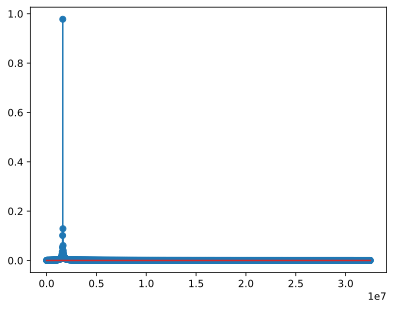

In [7]:
omega_test, fft_test = calculate_signal_fft(time_axis, data_in[2], sample_rate)
plt.figure()
plt.stem(omega_test, np.abs(fft_test))
plt.show()

In [8]:
"""
""" Period depended bin size """
# system constants:
start = 20e3
stop = 1.3e6
sample_rate = 65e6
periods_per_bin = 10
n_sweeps = 100

# get logspace containing frequencies
bin_logspace = get_log_space(start, stop, n_sweeps)

# get omega axis
bin_size = get_bin_size(start, periods_per_bin, sample_rate)
duration = get_duration(bin_size, sample_rate)
data_in, time_axis, data_out = generate_data(start, sample_rate, duration)
omega_init, fft_init = calculate_signal_fft(time_axis, data_in, sample_rate)

 # max bin size
max_bin_size = omega_init.size

# initialize data bins
data_in_fft = np.zeros((n_sweeps, int(max_bin_size)))
data_out_fft = np.zeros((n_sweeps, int(max_bin_size)))
magnitude_response = np.zeros((n_sweeps, int(max_bin_size)))
phase_response = np.zeros((n_sweeps, int(max_bin_size)))
index_max = np.zeros(n_sweeps, dtype=int)

# Loop for each bin size (or frequency)
for i, frequency in enumerate(bin_logspace):
    # Get bin size and duration
    bin_size = get_bin_size(frequency, periods_per_bin, sample_rate)
    duration = get_duration(bin_size, sample_rate)

    # get time data
    data_in, time_axis, data_out = generate_data(frequency, sample_rate, duration)

    # get fft
    omega_in, fft_in = calculate_signal_fft(time_axis, data_in, sample_rate)
    omega_out, fft_out = calculate_signal_fft(time_axis, data_out, sample_rate)   

    # scale fft to max bin size
    data_in_fft[i,:] = scale_axis(np.abs(fft_in), max_bin_size)
    data_out_fft[i,:] = scale_axis(np.abs(fft_out), max_bin_size)

    # Store max index of input fft
    index_max[i] = int(np.where(data_in_fft[i,:] == np.max(data_in_fft[i,:]))[0])

    # get total power output fft
    input_power = data_in_fft[i,index_max[i]]
    output_power = data_out_fft[i,index_max[i]]
    
    # Get phase
    index_max_phase = int(np.where(np.abs(fft_in) == np.max(np.abs(fft_in)))[0])
    phase_axis = np.zeros(fft_in.size)
    original_size = fft_in.size
    bin_ratio = max_bin_size / original_size
    scaled_index = int((index_max_phase)*bin_ratio)
    
    # axis_scaled[int(i*bin_ratio)] = axis[i]

    input_phasor = fft_in[index_max_phase]
    output_phasor = fft_out[index_max_phase]
    tf = output_phasor/input_phasor
    phase = np.arctan(np.imag(tf)/np.real(tf))

    phase_axis[index_max_phase] = phase
    phase_response[i,:] = scale_axis(phase_axis, max_bin_size)
    
    power_mag_response = output_power/input_power

    # Store it at index max power input
    magnitude_response[i,int(index_max[i])] = power_mag_response

magnitude_tf_mean, magnitude_tf_indices = mean_transfer(magnitude_response)
phase_tf_mean, phase_tf_indeces = mean_transfer(phase_response)

f_cutoff = 1.58e6
num, den = signal.butter(1, [f_cutoff], analog=False,btype='lowpass', fs=sample_rate)
w,h = signal.freqz(num, den)
w_lin = np.linspace(0,sample_rate/2, num=512)

outliers = np.where((np.rad2deg(phase_tf_mean)>-15) & (omega_init > 6e5) & (np.abs(phase_tf_mean)>0) )

plt.figure()
# plt.scatter(omega_init[outliers],  np.rad2deg(phase_tf_mean[outliers]), color='red')
plt.scatter(omega_init[phase_tf_indeces], np.rad2deg(phase_tf_mean[phase_tf_indeces]), marker='.', color='red', label="Measured Response")
plt.semilogx(w_lin,  np.rad2deg(np.unwrap(np.angle(h))), ls='dashed', label='Simulated Response')
plt.grid(which='both', axis='both')
plt.xlim([start, stop])
plt.ylim([np.min(np.rad2deg(phase_tf_mean[phase_tf_indeces])), np.max(np.rad2deg(phase_tf_mean[phase_tf_indeces]))])
# plt.vlines(500_000,ymin=0, ymax=-8, ls='dashed', color='green',label="-3dB frequency")
# plt.hlines(-3,xmin=start, xmax=stop, ls='dashed', color='green')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degrees)")
plt.legend()
plt.show()

y_max = np.max(20*np.log10(magnitude_tf_mean[magnitude_tf_indices]))
y_min = np.min(20*np.log10(magnitude_tf_mean[magnitude_tf_indices]))
plt.figure()
plt.scatter(omega_init[magnitude_tf_indices], 20*np.log10(magnitude_tf_mean[magnitude_tf_indices]), marker='.', color='red', label="Measured Response")
plt.semilogx(w_lin,  20*np.log10(np.abs(h)), ls='dashed', label='Simulated Response')
plt.grid(which='both', axis='both')
plt.xlim([start, stop])
plt.ylim([y_min, y_max])
plt.vlines(500_000,ymin=y_min, ymax=y_max, ls='dashed', color='green',label="-3dB frequency")
plt.hlines(-3,xmin=start, xmax=stop, ls='dashed', color='green')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.show()

"""

SyntaxError: invalid syntax (2967383901.py, line 2)